# CNN Model - 2018 Paper (Kachuee, Fazeli, Sarrafzadeh): CNN7

- with added dropout
- removed 1 fully connected layer at the end

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten, Add, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, RandomOverSampler

import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.config.list_physical_devices('GPU'))  # should show []
from contextlib import redirect_stdout
import json

from src.visualization.visualization import plot_training_history

2025-10-30 17:41:35.150477: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-30 17:41:35.567132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 17:41:37.382267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


[]


2025-10-30 17:41:38.304209: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
SAMPLING_METHOD = "SMOTE"
REMOVE_OUTLIERS = False
model_name = "cnn7_sm"
OUTPUT_PATH = "src/models/CNN/"
results_csv = "reports/03_model_testing_results/05_CNN_model_comparison.csv"
EPOCHS = 50

#import MIT data
df_mitbih_test = pd.read_csv('data/original/mitbih_test.csv', header = None)

X_train = pd.read_csv('data/processed/mitbih/X_train.csv')
y_train = pd.read_csv('data/processed/mitbih/y_train.csv')
y_train = y_train['187']

X_train_sm = pd.read_csv('data/processed/mitbih/X_train_sm.csv')
y_train_sm = pd.read_csv('data/processed/mitbih/y_train_sm.csv')
y_train_sm = y_train_sm['187']

X_val = pd.read_csv('data/processed/mitbih/X_val.csv')
y_val = pd.read_csv('data/processed/mitbih/y_val.csv')
y_val = y_val['187']

X_test = df_mitbih_test.drop(187, axis = 1)
y_test = df_mitbih_test[187]


# Reshape the data for 1D CNN
X_train_sm_cnn = np.expand_dims(X_train_sm, axis=2)
X_val_cnn = np.expand_dims(X_val, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2) 

display(X_train_sm_cnn.shape)
display(X_val_cnn.shape)
display(X_test_cnn.shape)

(289885, 187, 1)

(17511, 187, 1)

(21892, 187, 1)

In [3]:
# Input layer
input_layer = Input(shape=(187, 1))

conv_0 = Conv1D(filters=32, kernel_size=5, padding='same')(input_layer)

# Initial convolution
conv_0 = Conv1D(filters=32, kernel_size=5, padding='same')(input_layer)

# ----- Residual Block 1 -----
x = Conv1D(32, 5, padding='same', activation='relu')(conv_0)
x = Conv1D(32, 5, padding='same')(x)
x = Add()([conv_0, x])
x = ReLU()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.1)(x) 

# ----- Residual Block 2 -----
shortcut = x
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Conv1D(32, 5, padding='same')(x)
x = Add()([shortcut, x])
x = ReLU()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.1)(x) 

# ----- Residual Block 3 -----
shortcut = x
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Conv1D(32, 5, padding='same')(x)
x = Add()([shortcut, x])
x = ReLU()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.1)(x) 

# ----- Residual Block 4 -----
shortcut = x
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Conv1D(32, 5, padding='same')(x)
x = Add()([shortcut, x])
x = ReLU()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.1)(x) 

# ----- Residual Block 5 -----
shortcut = x
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Conv1D(32, 5, padding='same')(x)
x = Add()([shortcut, x])
x = ReLU()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
x = Dropout(0.1)(x) 

# Fully connected layers
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x) 
output_layer = Dense(5, activation='softmax')(x)

# Model
cnn = Model(inputs=input_layer, outputs=output_layer)

In [4]:
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 187, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 187, 32)   │      5,152 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 187, 32)   │      5,152 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 32)   │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 187, 32)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 94, 32)    │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 94, 32)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 94, 32)    │      5,152 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 94, 32)    │      5,152 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 94, 32)    │          0 │ dropout[0][0],    │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 94, 32)    │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 47, 32)    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 47, 32)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 47, 32)    │      5,152 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 47, 32)    │      5,152 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 47, 32)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 47, 32)    │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 24, 32)    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 32)    │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 24, 32)    │      5,152 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 58,053 (226.77 KB)

 Trainable params: 58,053 (226.77 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Learning rate with exponential decay
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.75,
    staircase=True
)

# Adam optimizer with specified hyperparameters
optimizer = Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999
)


# Compile the model
cnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

# Define where and how to save the best model
checkpoint = ModelCheckpoint(
    filepath=OUTPUT_PATH+model_name+'_bs_epoch_{epoch:02d}_valloss_{val_loss:.4f}.keras',   # file path (can be .keras or .h5)
    monitor='val_loss',        # metric to monitor
    mode='min',                    # because higher accuracy is better
    save_best_only=True,           # only save when val_accuracy improves
    verbose=1                      # print message when a model is saved
)

In [6]:
history = cnn.fit(
    X_train_sm_cnn,
    y_train_sm,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(X_val_cnn, y_val),  
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
2264/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7949 - loss: 0.5381
Epoch 1: val_loss improved from None to 0.28026, saving model to src/models/CNN/cnn7_sm_bs_epoch_01_valloss_0.2803.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - accuracy: 0.8891 - loss: 0.3089 - val_accuracy: 0.8999 - val_loss: 0.2803
Epoch 2/50
2263/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9537 - loss: 0.1365
Epoch 2: val_loss improved from 0.28026 to 0.14198, saving model to src/models/CNN/cnn7_sm_bs_epoch_02_valloss_0.1420.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.9576 - loss: 0.1266 - val_accuracy: 0.9513 - val_loss: 0.1420
Epoch 3/50
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9680 - loss: 0.0965
Epoch 3: val_loss improved from 0.14198 to 0.14191, saving model to src/models/CNN/cnn7_sm_bs_epoch_03_valloss_0.1419.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.9698 - loss: 0.0926 - val_accuracy: 0.9444 - val_loss: 0.1419
E

In [7]:
from pathlib import Path
import re 
def parse_epoch_from_name(name, default_epochs=EPOCHS):
    # Expect pattern like ..._epoch_12_...; returns int if found else default
    m = re.search(r"epoch_(\d+)", name)
    return int(m.group(1)) if m else default_epochs

def parse_val_loss_from_name(name):
    # Expect pattern like ..._valloss_0.1234.keras
    m = re.search(r"valloss_([0-9]+\.[0-9]+)", name)
    return float(m.group(1)) if m else np.nan

# Safer file filtering
model_dir = Path(OUTPUT_PATH)
model_paths = sorted([p for p in model_dir.glob("*.keras")])
model_paths = [p for p in model_paths if model_name in p.name]

all_labels = np.unique(y_test)  # ground-truth labels present in test set
rows = []

print(all_labels)

for p in model_paths:
    print(p)
    model_ = load_model(str(p))

    y_pred = model_.predict(X_test_cnn)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Force consistent label space for metrics
    print(classification_report(y_test, y_pred_class, digits=4))
    report = classification_report(
        y_test, y_pred_class, labels=all_labels, output_dict=True, zero_division=0
    )

    print(pd.crosstab(y_test, y_pred_class, colnames=['Predictions']))

    accuracy = accuracy_score(y_test, y_pred_class)
    epoch_num = parse_epoch_from_name(p.name)
    val_loss = parse_val_loss_from_name(p.name)

    row = {
        "sampling_method": SAMPLING_METHOD,
        "outliers_removed": REMOVE_OUTLIERS,
        "epochs": epoch_num,
        "model": p.name,
        "val_loss": round(float(val_loss), 4) if not np.isnan(val_loss) else np.nan,
        "test_accuracy": round(float(accuracy), 4),
        "test_f1_macro": round(float(report["macro avg"]["f1-score"]), 4),
        "test_precision_macro": round(float(report["macro avg"]["precision"]), 4),
        "test_recall_macro": round(float(report["macro avg"]["recall"]), 4),
        "test_f1_weighted": round(float(report["weighted avg"]["f1-score"]), 4),
        "test_precision_weighted": round(float(report["weighted avg"]["precision"]), 4),
        "test_recall_weighted": round(float(report["weighted avg"]["recall"]), 4),
    }
    for lbl in all_labels:
        row[f"test_f1_cls_{int(lbl)}"] = round(float(report[str(lbl)]["f1-score"]), 4)
        row[f"test_precision_cls_{int(lbl)}"] = round(float(report[str(lbl)]["precision"]), 4)
        row[f"test_recall_cls_{int(lbl)}"] = round(float(report[str(lbl)]["recall"]), 4)
        row[f"test_support_cls_{int(lbl)}"] = int(report[str(lbl)]["support"])

    rows.append(row)

df = pd.DataFrame(rows)
os.makedirs(os.path.dirname(results_csv), exist_ok=True)
if os.path.exists(results_csv):
    df.to_csv(results_csv, mode='a', index=False, header=False)
else:
    df.to_csv(results_csv, index=False)

[0. 1. 2. 3. 4.]
src/models/CNN/cnn7_sm_bs_epoch_01_valloss_0.2803.keras
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

         0.0     0.9950    0.8925    0.9409     18118
         1.0     0.3112    0.8525    0.4560       556
         2.0     0.8673    0.9392    0.9019      1448
         3.0     0.1759    0.9568    0.2972       162
         4.0     0.9538    0.9894    0.9713      1608

    accuracy                         0.9022     21892
   macro avg     0.6607    0.9261    0.7135     21892
weighted avg     0.9601    0.9022    0.9235     21892

Predictions      0     1     2    3     4
187                                      
0.0          16170  1026   187  661    74
1.0             60   474    13    8     1
2.0             15    16  1360   55     2
3.0              2     1     4  155     0
4.0              5     6     4    2  1591
src/models/CNN/cnn7_sm_bs_epoch_02_valloss_0.1420.keras
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
      

Saved: reports/figures/training_history/cnn7_sm_accuracy.png


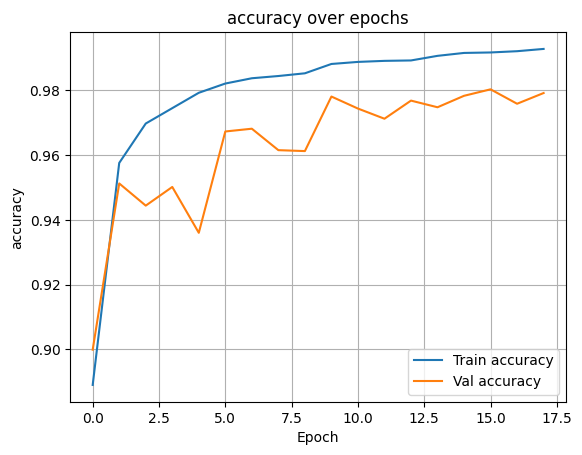

Saved: reports/figures/training_history/cnn7_sm_loss.png


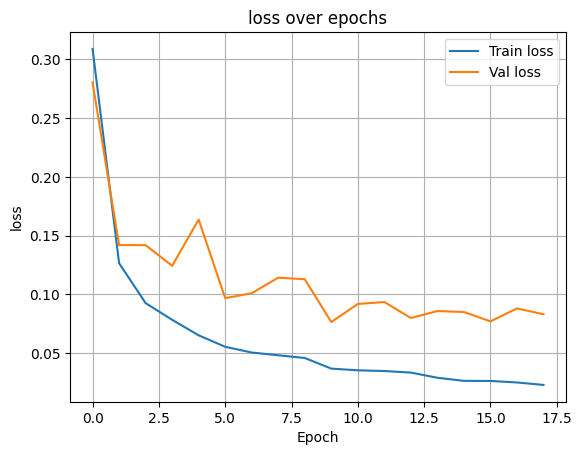

In [8]:
plot_training_history(history, "reports/figures/training_history/", model_name)